想要将深度学习用于小型图像数据集，一种常用且非常高效的方法是使用预训练的卷积神经网络。  
**预训练网络(pretrained network)是一个保存好的网络，之前已在大型数据集上训练好。**   
如果这个原始数据集足够大且足够通用，那么预训练的网络学到的特征的空间层次结构可以有效地作为视觉世界的通用模型，因此这些特征可以用于不同的计算机问题，即使这些新问题涉及的类别和原始任务完全不同。这种学到的特征在不同问题之间的可移植性，使得深度学习在对小数据问题非常有效。  
**使用预训练的网络有两种方法：**
* 特征提取(feature extraction)
* 微调模型(fine-tuning)

## 5.3.1 特征提取
特征提取是使用之前的网络学到的表示来从新样本中提取出有趣的特征，然后从这些特征中输入一个新的分类器，从头开始训练。  
对于卷积神经网络而言，特征提取就是取出之前训练好的卷积基，在上面运行新数据，然后在输出上面训练一个新的分类器
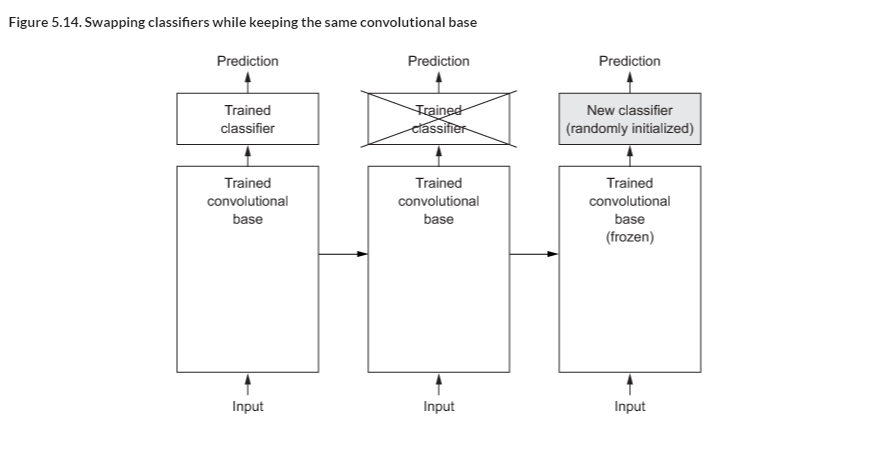

一、将VGG16卷积基实例化

In [23]:
from tensorflow.keras.applications import VGG16

#weights指定了模型初始化的权重检查点，include_top指定模型最后是否包含密集连接分类器，
#input_shape是输入到网络中图像张量的形状，如果不指定，那么网络可以处理任意形状的输入
conv_base = VGG16(weights = 'imagenet',
                  include_top = False,
                  input_shape =  (150, 150, 3))

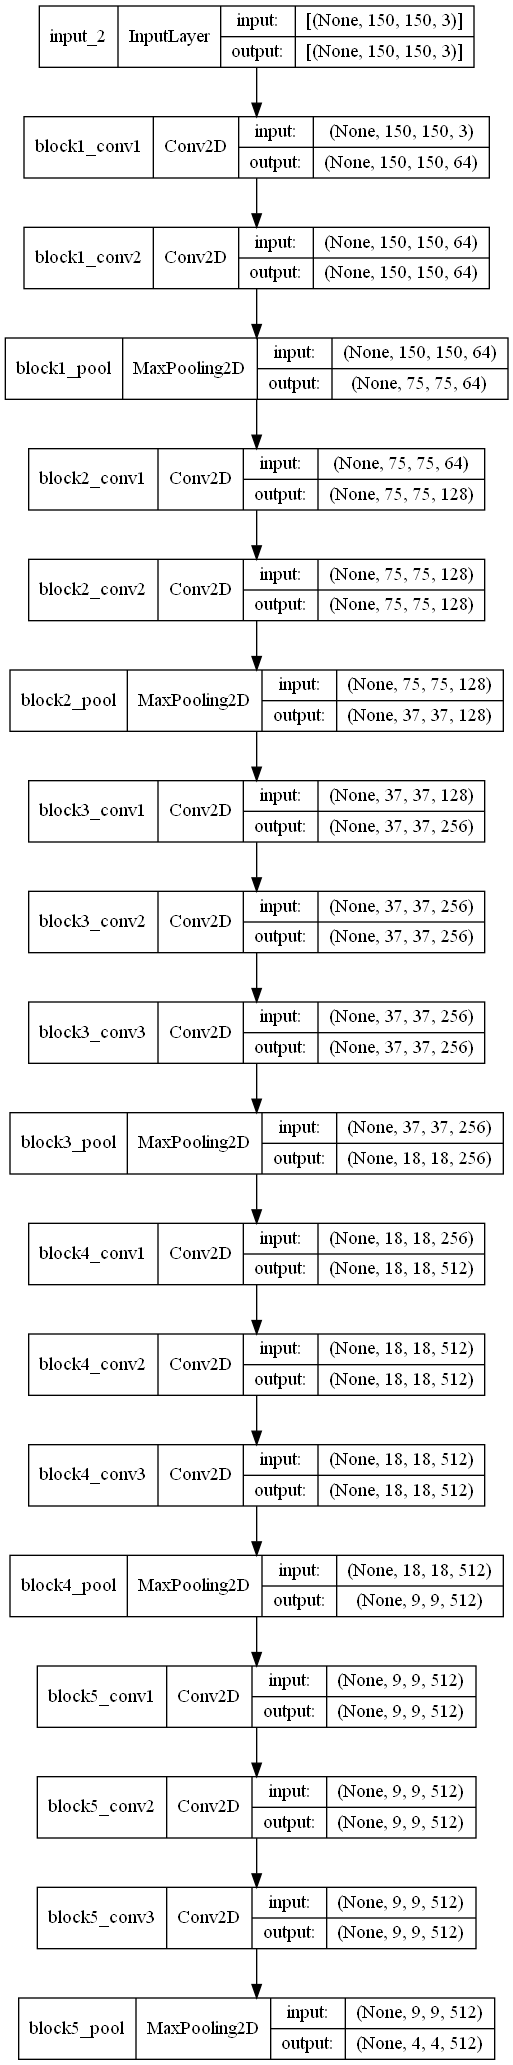

In [24]:
from tensorflow.keras.utils import plot_model

plot_model(conv_base, show_shapes = True, to_file = 'VGG16.png')

### 1、不使用数据增强的快速特征提取
**在数据集上运行卷积基，将输出保存为Numpy数组，然后用这个数据作为输入，输入到密集连接的分类器中**  
这种方法速度快、计算代价低，因为对每个输入图像只运行一次卷积基，而卷积基是目前流程中计算代价最高的，  
但出于同样原因，这种方法不允许你使用数据增强
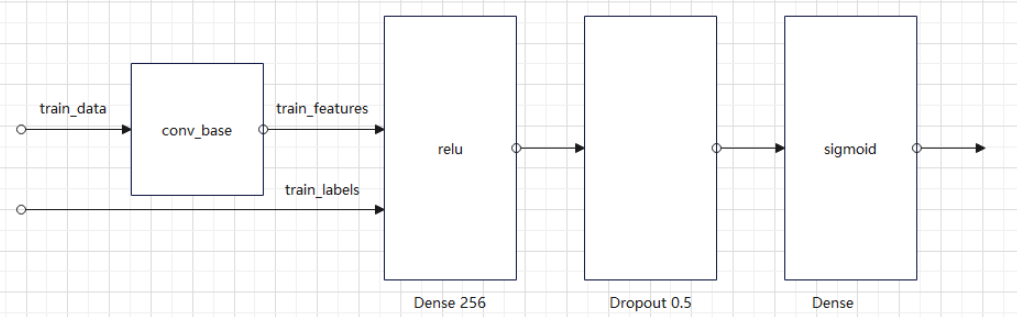

In [25]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_dir = 'D:\\BaiduNetdisk\\kaggle\\cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale = 1.0 / 255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape = (sample_count, 4, 4, 512))
    labels = np.zeros(shape = (sample_count))
    
    generator = datagen.flow_from_directory(
        directory,
        target_size = (150 , 150),
        batch_size = batch_size,
        class_mode = 'binary')
    
    i = 0
    
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch) #使用conv_base做特征提取
        features[i * batch_size : (i+1) * batch_size] = features_batch
        labels[i * batch_size : (i+1) * batch_size]= labels_batch
        
        i += 1
        if i * batch_size >= sample_count:
            break
        
    return features, labels

In [26]:
train_features, train_labels = extract_features(train_dir, 2000) 
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000) 

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


提取到的特征形状为(samples, 4, 4, 512)，我们要将其输入连接到密集连接分类器中，首先必须将其形状转为(samples, 4 * 4 * 512)

In [27]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

定义并训练密集连接分类器

In [28]:
from keras import models,layers
from tensorflow import optimizers

network = models.Sequential()
network.add(layers.Dense(256, activation = 'relu', input_dim = 4 * 4 * 512))
network.add(layers.Dropout(0.5))
network.add(layers.Dense(1, activation = 'sigmoid'))

network.compile(optimizer = optimizers.RMSprop(learning_rate = 2e-5),
                loss = 'binary_crossentropy', 
                metrics = ['accuracy'])

history = network.fit(train_features, train_labels, epochs = 30, batch_size = 20,
                      validation_data = (validation_features, validation_labels))

Epoch 1/30
100/100 [==============================] - 2s 21ms/step - loss: 0.6093 - accuracy: 0.6650 - val_loss: 0.4329 - val_accuracy: 0.8450
Epoch 2/30
100/100 [==============================] - 2s 24ms/step - loss: 0.4301 - accuracy: 0.7965 - val_loss: 0.3572 - val_accuracy: 0.8660
Epoch 3/30
100/100 [==============================] - 2s 22ms/step - loss: 0.3613 - accuracy: 0.8450 - val_loss: 0.3183 - val_accuracy: 0.8850
Epoch 4/30
100/100 [==============================] - 2s 21ms/step - loss: 0.3140 - accuracy: 0.8650 - val_loss: 0.2958 - val_accuracy: 0.8870
Epoch 5/30
100/100 [==============================] - 2s 20ms/step - loss: 0.2799 - accuracy: 0.8890 - val_loss: 0.2777 - val_accuracy: 0.8930
Epoch 6/30
100/100 [==============================] - 2s 19ms/step - loss: 0.2629 - accuracy: 0.8955 - val_loss: 0.2691 - val_accuracy: 0.8990
Epoch 7/30
100/100 [==============================] - 2s 17ms/step - loss: 0.2465 - accuracy: 0.9065 - val_loss: 0.2591 - val_accuracy: 0.9020

绘制结果

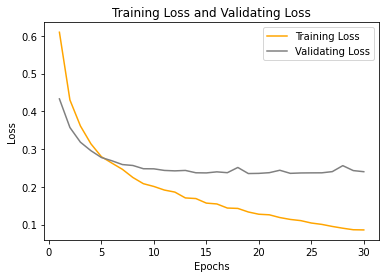

In [29]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'orange', label = 'Training Loss')
plt.plot(epochs, val_loss, 'grey', label = 'Validating Loss')
plt.title('Training Loss and Validating Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

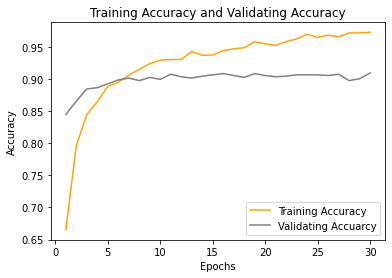

In [30]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.plot(epochs, accuracy, 'orange', label = 'Training Accuracy')
plt.plot(epochs, val_accuracy, 'grey', label = 'Validating Accuarcy')
plt.title("Training Accuracy and Validating Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [31]:
max(val_accuracy)

0.9100000262260437

画出二分类的混淆矩阵

In [32]:
prediction = network.predict(test_features)

In [33]:
prediction = [(int) ((p + 0.5) / 1.0) for p in prediction]
prediction = np.asarray(prediction).astype('float32')

In [34]:
import pandas as pd

pd.crosstab(test_labels, prediction, rownames = ['labels'], colnames = ['prediction'])

prediction,0.0,1.0
labels,,
0.0,448,52
1.0,64,436


In [35]:
from sklearn.metrics import classification_report

print(classification_report(test_labels, prediction))

              precision    recall  f1-score   support

         0.0       0.88      0.90      0.89       500
         1.0       0.89      0.87      0.88       500

    accuracy                           0.88      1000
   macro avg       0.88      0.88      0.88      1000
weighted avg       0.88      0.88      0.88      1000



# 2、使用数据增强的特征提取

在卷积基上添加一个密集连接分类器

In [36]:
from keras import models, layers

network = models.Sequential()
network.add(conv_base)
network.add(layers.Flatten())
network.add(layers.Dense(256, activation = 'relu'))
network.add(layers.Dense(1, activation = 'sigmoid'))

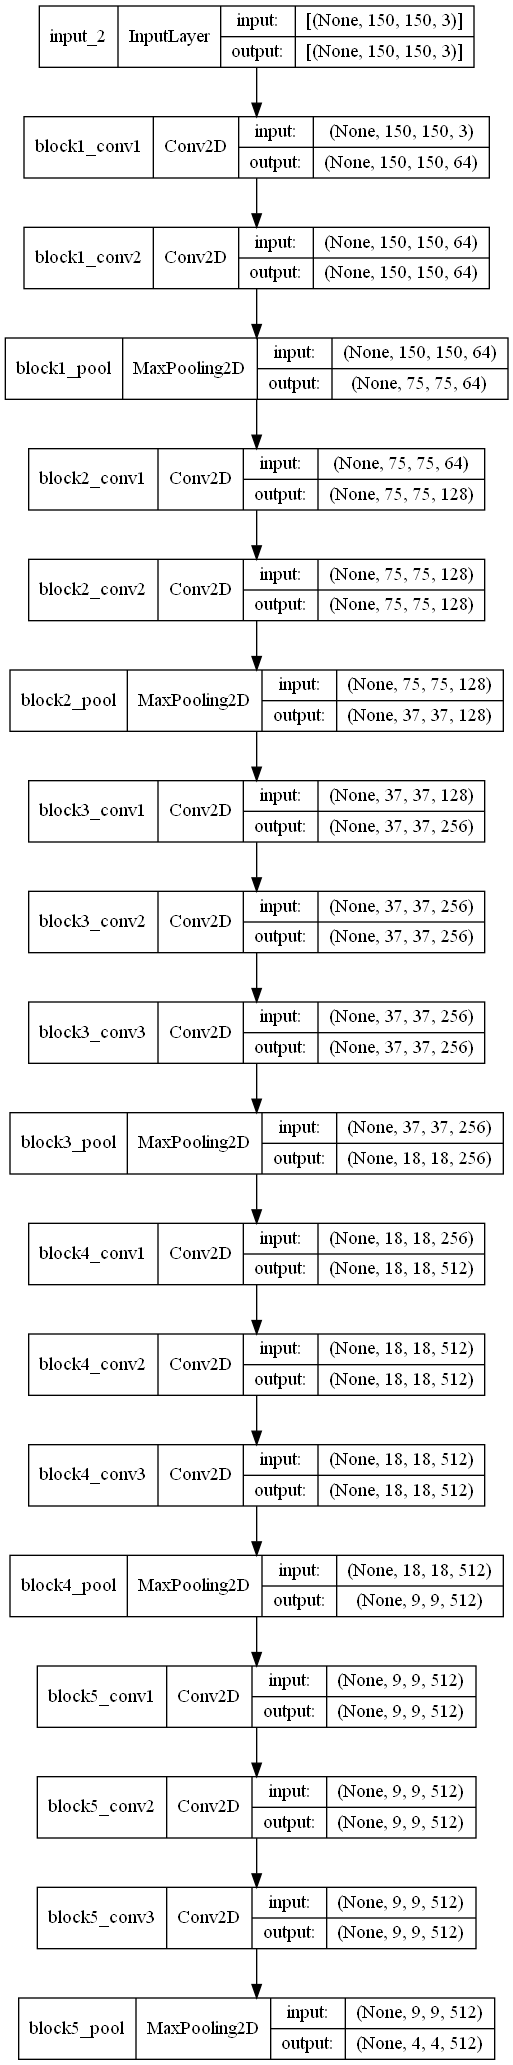

In [37]:
from tensorflow.keras.utils import plot_model

plot_model(conv_base, show_shapes = True)

In [38]:
#查看网络中的参数
network.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_6 (Dense)             (None, 256)               2097408   
                                                                 
 dense_7 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


VGG16的卷积基参数有14 714 688个，非常多，在其上添加的分类器有200万个参数。  
**在编译和训练模型之前，一定要“冻结”卷积基。  
冻结(freeze)一个层或多个层是指在训练过程中保持其权重不变，如果不这么做，那么卷积基之前学到的表示会在训练过程中被修改。**  
因为其上添加的Dense层是随机初始化的，所以非常大的权重更新将在网络中传播，对之前学到的表示造成很大的破坏。

In [39]:
#在keras中冻结卷积基的方法是将其trainable属性设为False
conv_base.trainable = False

利用冻结的卷积基端到端训练模型

In [40]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import optimizers

train_datagen = ImageDataGenerator(rescale = 1.0 / 255, rotation_range = 40, width_shift_range = 0.2,
                                   height_shift_range = 0.2,shear_range = 0.2, zoom_range = 0.2, 
                                   horizontal_flip = True, fill_mode = 'nearest')

test_datagen = ImageDataGenerator(rescale = 1.0 / 255)
validation_datagen = ImageDataGenerator(rescale = 1.0 / 255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size = (150, 150),
        batch_size = 20, 
        class_mode = 'binary')

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size = (150, 150),
        batch_size = 20,
        class_mode = 'binary')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size = (150, 150),
        batch_size = 20,
        class_mode = 'binary')

network.compile(optimizer = optimizers.RMSprop(learning_rate = 2e-5),
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [41]:
history = network.fit_generator(train_generator, steps_per_epoch = 100, epochs = 30, 
                                validation_data = validation_generator, validation_steps = 50)

<ipython-input-41-8ee45f34e7f4>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = network.fit_generator(train_generator, steps_per_epoch = 100, epochs = 30,


Epoch 1/30
100/100 [==============================] - 102s 1s/step - loss: 0.5831 - accuracy: 0.6985 - val_loss: 0.4488 - val_accuracy: 0.8210
Epoch 2/30
100/100 [==============================] - 99s 992ms/step - loss: 0.4886 - accuracy: 0.7775 - val_loss: 0.3800 - val_accuracy: 0.8530
Epoch 3/30
100/100 [==============================] - 95s 952ms/step - loss: 0.4299 - accuracy: 0.8095 - val_loss: 0.3342 - val_accuracy: 0.8720
Epoch 4/30
100/100 [==============================] - 95s 957ms/step - loss: 0.4050 - accuracy: 0.8260 - val_loss: 0.3089 - val_accuracy: 0.8780
Epoch 5/30
100/100 [==============================] - 97s 976ms/step - loss: 0.3811 - accuracy: 0.8360 - val_loss: 0.2923 - val_accuracy: 0.8840
Epoch 6/30
100/100 [==============================] - 102s 1s/step - loss: 0.3838 - accuracy: 0.8335 - val_loss: 0.2798 - val_accuracy: 0.8930
Epoch 7/30
100/100 [==============================] - 97s 975ms/step - loss: 0.3509 - accuracy: 0.8535 - val_loss: 0.2724 - val_accura

绘制结果

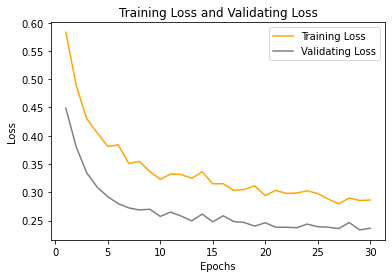

In [42]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'orange', label = 'Training Loss')
plt.plot(epochs, val_loss, 'grey', label = 'Validating Loss')
plt.title('Training Loss and Validating Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

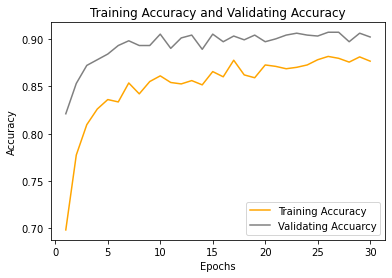

In [44]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.plot(epochs, accuracy, 'orange', label = 'Training Accuracy')
plt.plot(epochs, val_accuracy, 'grey', label = 'Validating Accuarcy')
plt.title("Training Accuracy and Validating Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [45]:
#构建二分类矩阵
import numpy as np

#test_dir中一共有1000张图片，所以prediction的shape是(1000, 1)，labels的shape是(1000)
prediction = np.zeros(shape = (1000, 1))
labels = np.zeros(shape = (1000))

i = 0
batch_size = 20
#从test_generator中读取输入和标签，利用输入来得到prediction
for inputs_batch, labels_batch in test_generator:
    prediction_batch = network.predict(inputs_batch) 
    prediction[i * batch_size : (i+1) * batch_size] = prediction_batch
    labels[i * batch_size : (i+1) * batch_size]= labels_batch

    i += 1
    if i * batch_size >= 1000:
        break
        
prediction = [(int) ((p + 0.5) / 1) for p in prediction]
prediction = np.asarray(prediction).astype('float32')

#得到一个二分类的表格
import pandas as pd

pd.crosstab(labels, prediction ,rownames = ['labels'], colnames = ['predictions'])

predictions,0.0,1.0
labels,,
0.0,453,47
1.0,60,440


In [46]:
#查看分类报告
from sklearn.metrics import classification_report

print(classification_report(labels, prediction))

              precision    recall  f1-score   support

         0.0       0.88      0.91      0.89       500
         1.0       0.90      0.88      0.89       500

    accuracy                           0.89      1000
   macro avg       0.89      0.89      0.89      1000
weighted avg       0.89      0.89      0.89      1000



# 3、模型微调

**微调(fine-tuning)是将其顶部的几层“解冻”，并将解冻的这几层和新增加的部分（全连接分类器）联合训练**  

微调网络的步骤如下：
* (1)在已经训练好的基网络(base network)上添加自定义网络
* (2)冻结基网络
* (3)训练所添加的部分
* (4)解冻基网络的一些层
* (5)联合训练这些层和添加的部分
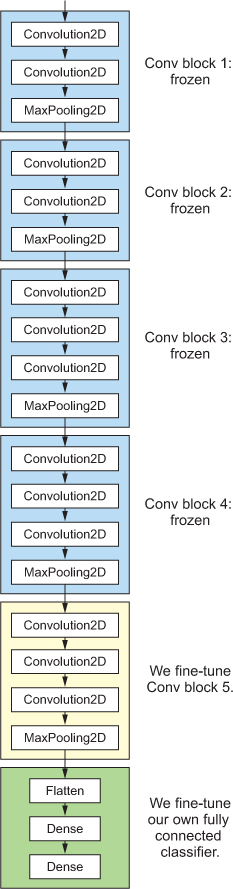

In [47]:
#查看基网络的架构
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [51]:
#查看网络中的层
for layer in conv_base.layers:
    print(layer.name)

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool


In [52]:
#冻结直到某一层的所有层
conv_base.trainable = True #先将基网络解冻

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [53]:
#微调网络，使用学习率非常小的RESprop优化器来实现
network.compile(optimizer = optimizers.RMSprop(learning_rate = 1e-5),
                loss = 'binary_crossentropy', 
                metrics = ['accuracy'])

In [55]:
history = network.fit_generator(train_generator, steps_per_epoch = 100, epochs = 30, 
                                validation_data = validation_generator, validation_steps = 50)

<ipython-input-55-8ee45f34e7f4>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = network.fit_generator(train_generator, steps_per_epoch = 100, epochs = 30,


Epoch 1/30
100/100 [==============================] - 115s 1s/step - loss: 0.3001 - accuracy: 0.8680 - val_loss: 0.2573 - val_accuracy: 0.8910
Epoch 2/30
100/100 [==============================] - 114s 1s/step - loss: 0.2642 - accuracy: 0.8825 - val_loss: 0.2051 - val_accuracy: 0.9220
Epoch 3/30
100/100 [==============================] - 112s 1s/step - loss: 0.2446 - accuracy: 0.8970 - val_loss: 0.1987 - val_accuracy: 0.9170
Epoch 4/30
100/100 [==============================] - 112s 1s/step - loss: 0.2211 - accuracy: 0.9105 - val_loss: 0.2029 - val_accuracy: 0.9200
Epoch 5/30
100/100 [==============================] - 117s 1s/step - loss: 0.2272 - accuracy: 0.8975 - val_loss: 0.2074 - val_accuracy: 0.9160
Epoch 6/30
100/100 [==============================] - 115s 1s/step - loss: 0.1874 - accuracy: 0.9175 - val_loss: 0.1859 - val_accuracy: 0.9290
Epoch 7/30
100/100 [==============================] - 119s 1s/step - loss: 0.1753 - accuracy: 0.9285 - val_loss: 0.1810 - val_accuracy: 0.9250

绘制结果

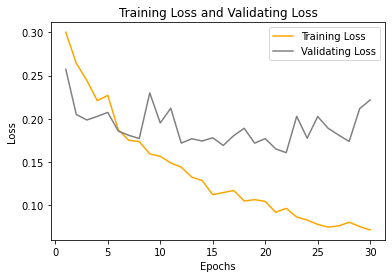

In [56]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'orange', label = 'Training Loss')
plt.plot(epochs, val_loss, 'grey', label = 'Validating Loss')
plt.title('Training Loss and Validating Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

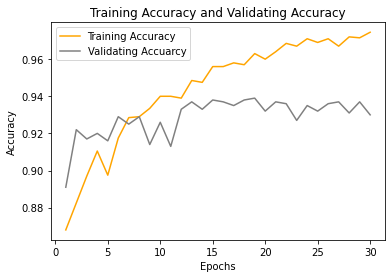

In [57]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.plot(epochs, accuracy, 'orange', label = 'Training Accuracy')
plt.plot(epochs, val_accuracy, 'grey', label = 'Validating Accuarcy')
plt.title("Training Accuracy and Validating Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

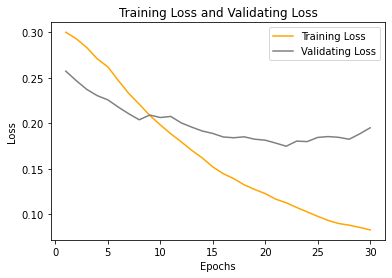

In [61]:
#使曲线变得平滑
def smooth_points(points, factor = 0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous =  smoothed_points[-1]
            smoothed_points.append(point * (1 - factor) + previous * factor)
        else :
            smoothed_points.append(point)
    return smoothed_points

import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, smooth_points(loss), 'orange', label = 'Training Loss')
plt.plot(epochs, smooth_points(val_loss), 'grey', label = 'Validating Loss')
plt.title('Training Loss and Validating Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

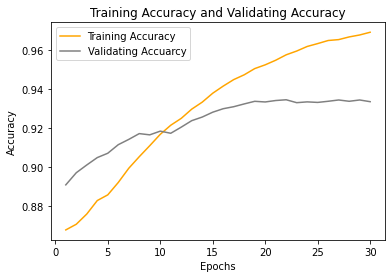

In [62]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.plot(epochs, smooth_points(accuracy), 'orange', label = 'Training Accuracy')
plt.plot(epochs, smooth_points(val_accuracy), 'grey', label = 'Validating Accuarcy')
plt.title("Training Accuracy and Validating Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [63]:
#构建二分类矩阵
import numpy as np

#test_dir中一共有1000张图片，所以prediction的shape是(1000, 1)，labels的shape是(1000)
prediction = np.zeros(shape = (1000, 1))
labels = np.zeros(shape = (1000))

i = 0
batch_size = 20
#从test_generator中读取输入和标签，利用输入来得到prediction
for inputs_batch, labels_batch in test_generator:
    prediction_batch = network.predict(inputs_batch) 
    prediction[i * batch_size : (i+1) * batch_size] = prediction_batch
    labels[i * batch_size : (i+1) * batch_size]= labels_batch

    i += 1
    if i * batch_size >= 1000:
        break
        
prediction = [(int) ((p + 0.5) / 1) for p in prediction]
prediction = np.asarray(prediction).astype('float32')

#得到一个二分类的表格
import pandas as pd

pd.crosstab(labels, prediction ,rownames = ['labels'], colnames = ['predictions'])

predictions,0.0,1.0
labels,,
0.0,452,48
1.0,18,482


In [64]:
#查看分类报告
from sklearn.metrics import classification_report

print(classification_report(labels, prediction))

              precision    recall  f1-score   support

         0.0       0.96      0.90      0.93       500
         1.0       0.91      0.96      0.94       500

    accuracy                           0.93      1000
   macro avg       0.94      0.93      0.93      1000
weighted avg       0.94      0.93      0.93      1000



在测试集上评估这个模型

In [66]:
test_loss, test_acc = network.evaluate(test_generator, steps = 50)

print(f"test_loss : {test_loss}")
print(f"test_acc : {test_acc}")

50/50 [==============================] - 32s 633ms/step - loss: 0.2445 - accuracy: 0.9340
test_loss : 0.2444877326488495
test_acc : 0.9340000152587891


### 小结
* 卷积神经网络CNN是用于计算机视觉的最佳机器学习模型。即使在非常小的数据集上也可以从头开始训练一个卷积神经网络，而且得到的结果还不错  
* 在小型数据集上的主要问题是过拟合，在处理图像数据时，数据增强是一中降低过拟合的强大方法
* 利用特征提取，可以很容易将现有的卷积神经网络复用于新的数据集，对于小型数据集，这是一种很有价值的方法
* 作为特征提取的补充，还可以使用微调，将现有模型学到的一些数据表示应用于新问题，可以进一步提高模型的性能